In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

# Model Selection & Metrics
from sklearn.model_selection import train_test_split, cross_val_score, KFold, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

# Metrics
from sklearn.metrics import accuracy_score, f1_score, mean_squared_error, r2_score

# Classifiers (For the "Active" flag)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB

# Regressors (For the "Affinity" score)
from sklearn.linear_model import LinearRegression, Ridge, BayesianRidge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor

# Configuration
DATA_PATH = 'data/dd_masterfile.csv'
RANDOM_SEED = 42
sns.set(style="whitegrid")

In [2]:
# 1. Load Data
df_full = pd.read_csv(DATA_PATH)
print(f"✅ Loaded dataset: {df_full.shape}")

# 2. Separate the "Blind Test" (10%)
# Stratify by 'active' to ensure both sets have a fair mix of active/inactive drugs
train_df, blind_test_df = train_test_split(
    df_full, 
    test_size=0.10, 
    stratify=df_full['active'], 
    random_state=RANDOM_SEED
)

print(f"   - Training Set: {train_df.shape[0]} samples")
print(f"   - Blind Test Set: {blind_test_df.shape[0]} samples (Locked away)")

# Save purely for safety/logging
train_df.to_csv('data/train_dataset.csv', index=False)
blind_test_df.to_csv('data/blind_test.csv', index=False)

✅ Loaded dataset: (2000, 17)
   - Training Set: 1800 samples
   - Blind Test Set: 200 samples (Locked away)


🛡️ Screening CLASSIFIERS on 1800 samples...
   Class Balance: {0: 0.6961111111111111, 1: 0.3038888888888889}

🏆 Classification Results (Accuracy)
--------------------------------------------------
Logistic Regression       | Accuracy: 0.9017 (±0.0112)
Naive Bayes               | Accuracy: 0.8922 (±0.0146)
KNN (Classifier)          | Accuracy: 0.8411 (±0.0118)
SVM (Classifier)          | Accuracy: 0.8883 (±0.0081)
Random Forest             | Accuracy: 0.9033 (±0.0126)
XGBoost (Classifier)      | Accuracy: 0.8889 (±0.0152)
Neural Net (MLP)          | Accuracy: 0.8706 (±0.0142)


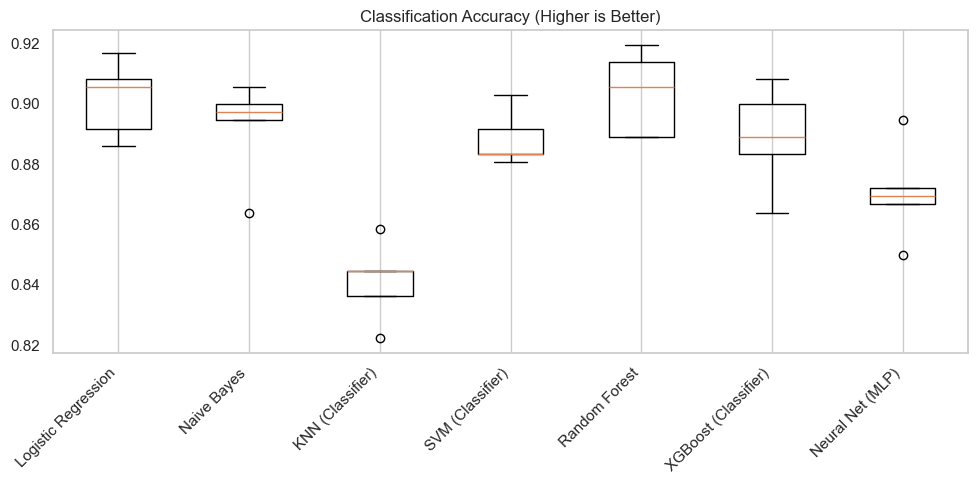

In [3]:
# 1. Setup Classification Data
target_class = 'active'
# CRITICAL: Drop the regression target ('binding_affinity') so we don't cheat!
cols_to_drop_class = ['compound_id', 'protein_id', 'binding_affinity', target_class]

X_class = train_df.drop(columns=[c for c in cols_to_drop_class if c in train_df.columns])
y_class = train_df[target_class]

print(f"🛡️ Screening CLASSIFIERS on {X_class.shape[0]} samples...")
print(f"   Class Balance: {y_class.value_counts(normalize=True).to_dict()}")

# 2. Pipeline (Impute -> Scale -> Classifier)
def get_class_pipeline(model):
    return Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler()),
        ('model', model)
    ])

# 3. Define Classifiers
classifiers = {
    "Logistic Regression": LogisticRegression(random_state=RANDOM_SEED),
    "Naive Bayes": GaussianNB(),
    "KNN (Classifier)": KNeighborsClassifier(),
    "SVM (Classifier)": SVC(probability=True, random_state=RANDOM_SEED),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=RANDOM_SEED),
    "XGBoost (Classifier)": xgb.XGBClassifier(eval_metric='logloss', random_state=RANDOM_SEED),
    "Neural Net (MLP)": MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=1000, random_state=RANDOM_SEED)
}

# 4. Run Screening (Stratified K-Fold)
results_class = []
names_class = []
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)

print("\n🏆 Classification Results (Accuracy)")
print("-" * 50)
for name, model in classifiers.items():
    pipeline = get_class_pipeline(model)
    # Using 'accuracy' as the metric
    cv_scores = cross_val_score(pipeline, X_class, y_class, cv=skf, scoring='accuracy')
    
    results_class.append(cv_scores)
    names_class.append(name)
    print(f"{name:<25} | Accuracy: {np.mean(cv_scores):.4f} (±{np.std(cv_scores):.4f})")

# 5. Visualize
plt.figure(figsize=(10, 5))
plt.boxplot(results_class, tick_labels=names_class)
plt.title('Classification Accuracy (Higher is Better)')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

🧪 Screening REGRESSORS on 1800 samples...

🏆 Regression Results (RMSE - Lower is Better)
--------------------------------------------------
Linear Regression         | RMSE: 0.7818 (±0.1079)
Ridge Regression          | RMSE: 0.7818 (±0.1079)
Bayesian Ridge            | RMSE: 0.7820 (±0.1078)
KNN (Regressor)           | RMSE: 0.9310 (±0.0927)
SVM (Regressor)           | RMSE: 0.8161 (±0.1038)
Random Forest             | RMSE: 0.8297 (±0.1027)
XGBoost (Regressor)       | RMSE: 0.8784 (±0.0846)
Neural Net (MLP)          | RMSE: 1.0547 (±0.1079)


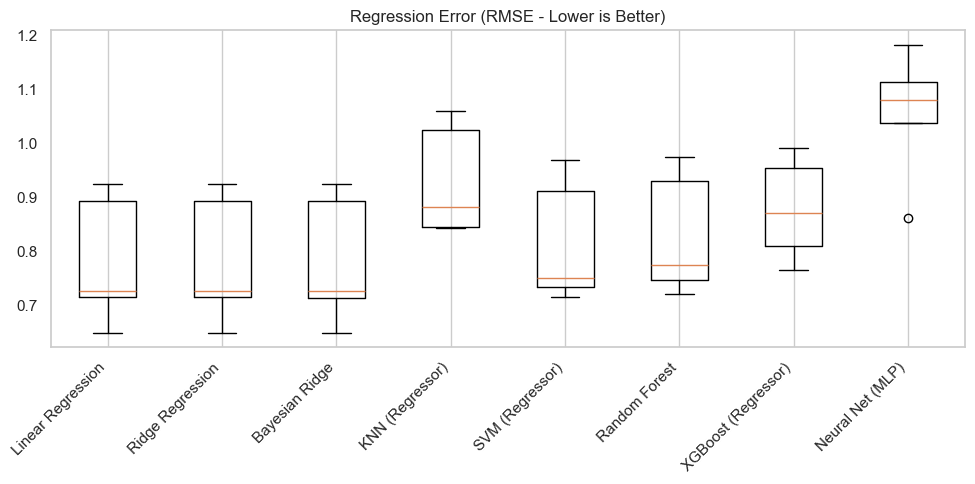

In [4]:
# 1. Setup Regression Data
target_reg = 'binding_affinity'
# CRITICAL: Drop the classification target ('active') to ensure the model learns chemistry, not just the flag.
cols_to_drop_reg = ['compound_id', 'protein_id', 'active', target_reg]

X_reg = train_df.drop(columns=[c for c in cols_to_drop_reg if c in train_df.columns])
y_reg = train_df[target_reg]

print(f"🧪 Screening REGRESSORS on {X_reg.shape[0]} samples...")

# 2. Pipeline (Impute -> Scale -> Regressor)
def get_reg_pipeline(model):
    return Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler()),
        ('model', model)
    ])

# 3. Define Regressors
regressors = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(),
    "Bayesian Ridge": BayesianRidge(),
    "KNN (Regressor)": KNeighborsRegressor(),
    "SVM (Regressor)": SVR(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=RANDOM_SEED),
    "XGBoost (Regressor)": xgb.XGBRegressor(objective='reg:squarederror', random_state=RANDOM_SEED),
    "Neural Net (MLP)": MLPRegressor(hidden_layer_sizes=(64, 32), max_iter=1000, random_state=RANDOM_SEED)
}

# 4. Run Screening (K-Fold)
results_reg = []
names_reg = []
kf = KFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)

print("\n🏆 Regression Results (RMSE - Lower is Better)")
print("-" * 50)
for name, model in regressors.items():
    pipeline = get_reg_pipeline(model)
    # Scoring is neg_root_mean_squared_error
    cv_scores = cross_val_score(pipeline, X_reg, y_reg, cv=kf, scoring='neg_root_mean_squared_error')
    
    rmse_scores = -cv_scores
    results_reg.append(rmse_scores)
    names_reg.append(name)
    print(f"{name:<25} | RMSE: {np.mean(rmse_scores):.4f} (±{np.std(rmse_scores):.4f})")

# 5. Visualize
plt.figure(figsize=(10, 5))
plt.boxplot(results_reg, tick_labels=names_reg)
plt.title('Regression Error (RMSE - Lower is Better)')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

📊 STAGE 1: Classification Diagnostics (Random Forest)


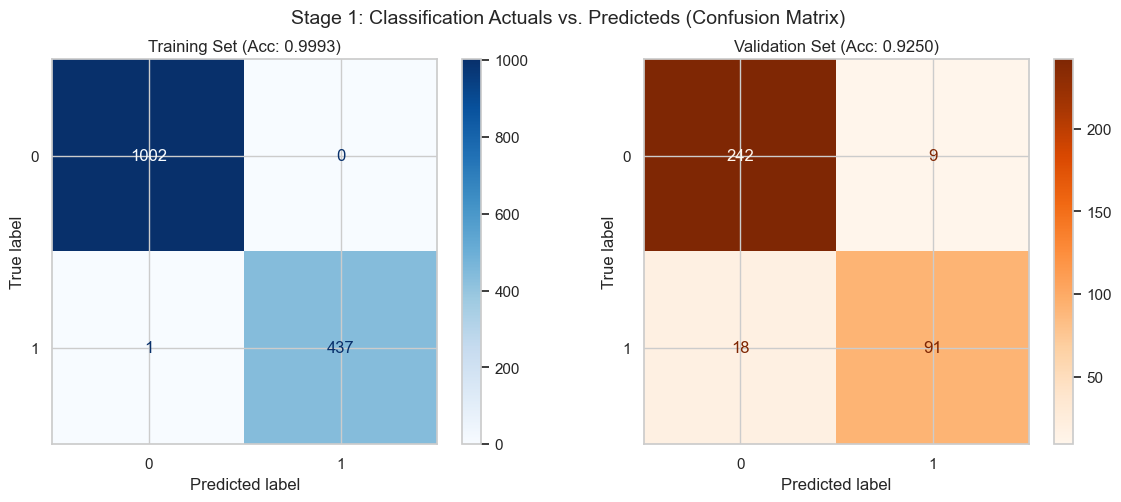

------------------------------------------------------------
📊 STAGE 2: Regression Diagnostics (Linear Regression)
   Training R²:   0.5652 | RMSE: 0.7977
   Validation R²: 0.5869 | RMSE: 0.7261


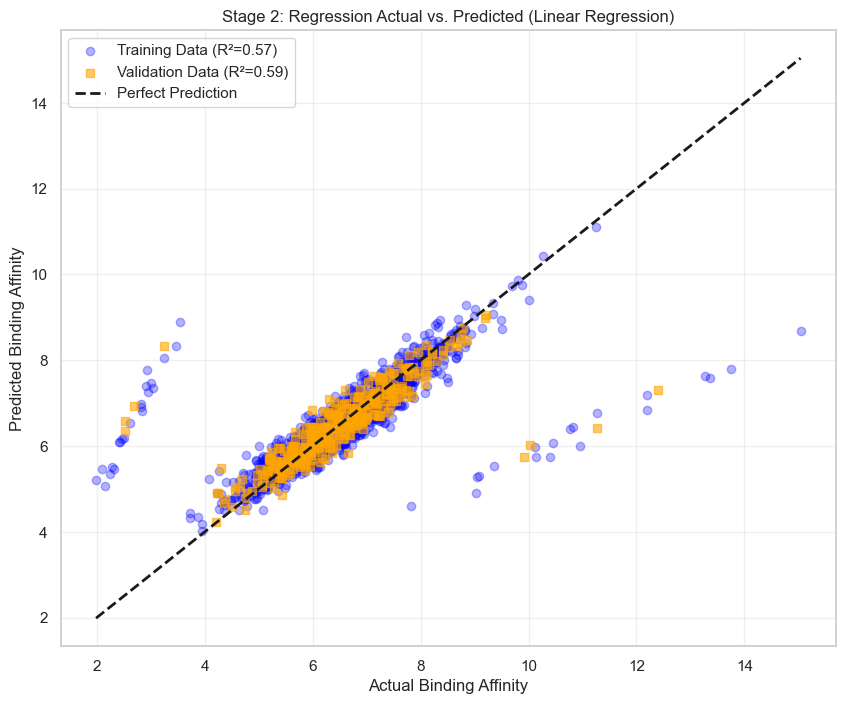

In [5]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, r2_score, mean_squared_error

# ==========================================
# PART A: Classification Visualization (Random Forest)
# ==========================================
print("📊 STAGE 1: Classification Diagnostics (Random Forest)")

# 1. Prepare Data (Drop regression target to prevent leakage)
# We perform a local split to create a validation set for plotting
X_class_full = train_df.drop(columns=[c for c in cols_to_drop_class if c in train_df.columns])
y_class_full = train_df['active']

X_train_c, X_val_c, y_train_c, y_val_c = train_test_split(
    X_class_full, y_class_full, test_size=0.2, stratify=y_class_full, random_state=RANDOM_SEED
)

# 2. Train Winner
clf = get_class_pipeline(RandomForestClassifier(n_estimators=100, random_state=RANDOM_SEED))
clf.fit(X_train_c, y_train_c)

# 3. Predict
y_train_pred_c = clf.predict(X_train_c)
y_val_pred_c = clf.predict(X_val_c)

# 4. Plot Confusion Matrices (Actual vs Predicted)
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Training Set
ConfusionMatrixDisplay.from_predictions(y_train_c, y_train_pred_c, ax=ax[0], cmap='Blues', normalize=None)
ax[0].set_title(f"Training Set (Acc: {accuracy_score(y_train_c, y_train_pred_c):.4f})")

# Validation Set
ConfusionMatrixDisplay.from_predictions(y_val_c, y_val_pred_c, ax=ax[1], cmap='Oranges', normalize=None)
ax[1].set_title(f"Validation Set (Acc: {accuracy_score(y_val_c, y_val_pred_c):.4f})")

plt.suptitle("Stage 1: Classification Actuals vs. Predicteds (Confusion Matrix)", fontsize=14)
plt.show()

print("-" * 60)

# ==========================================
# PART B: Regression Visualization (Linear Regression)
# ==========================================
print("📊 STAGE 2: Regression Diagnostics (Linear Regression)")

# 1. Prepare Data (Drop classification target)
X_reg_full = train_df.drop(columns=[c for c in cols_to_drop_reg if c in train_df.columns])
y_reg_full = train_df['binding_affinity']

# Local split
X_train_r, X_val_r, y_train_r, y_val_r = train_test_split(
    X_reg_full, y_reg_full, test_size=0.2, random_state=RANDOM_SEED
)

# 2. Train Winner
reg = get_reg_pipeline(LinearRegression())
reg.fit(X_train_r, y_train_r)

# 3. Predict
y_train_pred_r = reg.predict(X_train_r)
y_val_pred_r = reg.predict(X_val_r)

# 4. Metrics
r2_train = r2_score(y_train_r, y_train_pred_r)
r2_val = r2_score(y_val_r, y_val_pred_r)
rmse_train = np.sqrt(mean_squared_error(y_train_r, y_train_pred_r))
rmse_val = np.sqrt(mean_squared_error(y_val_r, y_val_pred_r))

print(f"   Training R²:   {r2_train:.4f} | RMSE: {rmse_train:.4f}")
print(f"   Validation R²: {r2_val:.4f} | RMSE: {rmse_val:.4f}")

# 5. Plot Actual vs Predicted
plt.figure(figsize=(10, 8))

# Training Data
plt.scatter(y_train_r, y_train_pred_r, 
            c='blue', alpha=0.3, label=f'Training Data (R²={r2_train:.2f})')

# Validation Data
plt.scatter(y_val_r, y_val_pred_r, 
            c='orange', alpha=0.6, marker='s', label=f'Validation Data (R²={r2_val:.2f})')

# Perfect Line
min_val = min(y_train_r.min(), y_val_r.min())
max_val = max(y_train_r.max(), y_val_r.max())
plt.plot([min_val, max_val], [min_val, max_val], 'k--', lw=2, label='Perfect Prediction')

plt.xlabel('Actual Binding Affinity')
plt.ylabel('Predicted Binding Affinity')
plt.title('Stage 2: Regression Actual vs. Predicted (Linear Regression)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

C:\Users\dwhan\AppData\Local\Temp\ipykernel_31080\4000641612.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(x=pred_active_bin, y=pred_affinity, ax=axes[0], alpha=0.5, jitter=0.2, palette="Set2")
C:\Users\dwhan\AppData\Local\Temp\ipykernel_31080\4000641612.py:50: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(x=y_act_val, y=y_aff_val, ax=axes[1], alpha=0.5, jitter=0.2, palette="Set1")


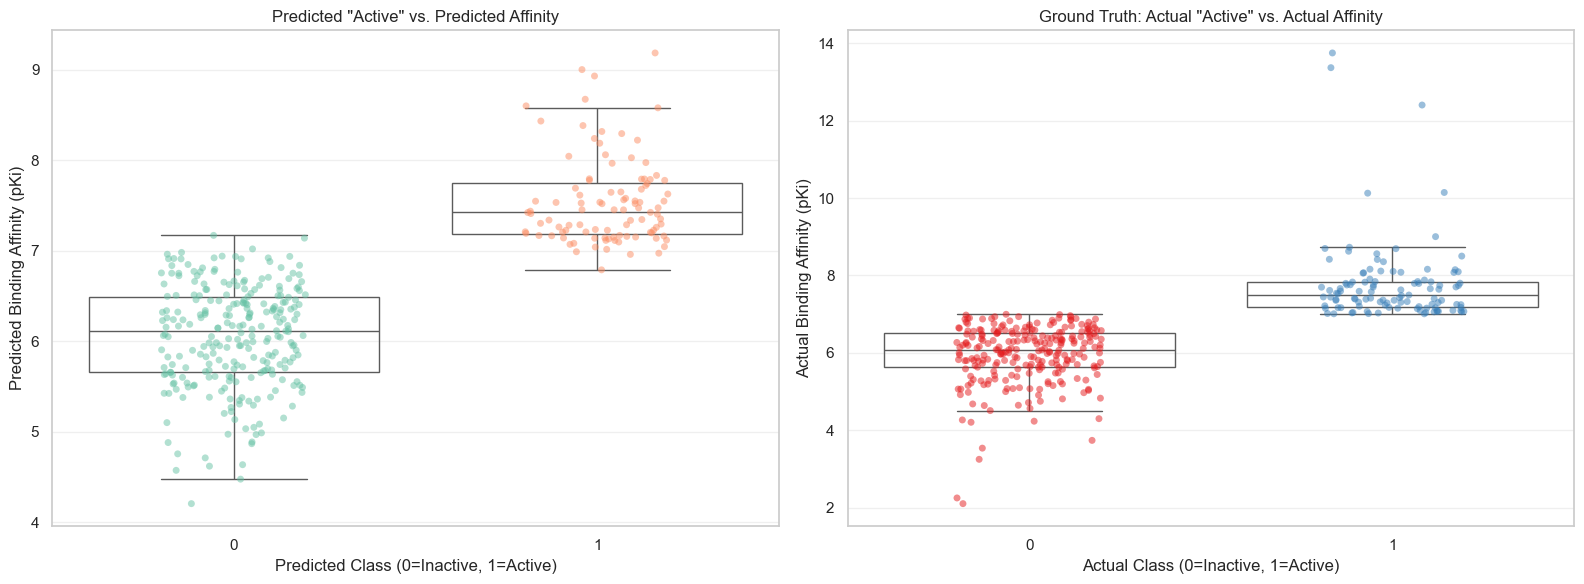

📊 Consistency Score:
   Correlation between Predicted Probability of Activity and Predicted Affinity: 0.8545
   (A high positive score means the models agree: 'Active' molecules usually have high affinity.)


In [7]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Unified Split (To ensure Alignment)
# We take the training pool and split it into Train/Val ONCE, keeping both targets.
# This ensures row 5 in 'val' is the same molecule for both models.
data_cols = [c for c in train_df.columns if c not in ['compound_id', 'protein_id', 'active', 'binding_affinity']]

X_unified = train_df[data_cols]
y_active = train_df['active']
y_affinity = train_df['binding_affinity']

# Split
X_train, X_val, y_act_train, y_act_val, y_aff_train, y_aff_val = train_test_split(
    X_unified, y_active, y_affinity, 
    test_size=0.2, 
    stratify=y_active, # Keep active/inactive balance
    random_state=RANDOM_SEED
)

# 2. Retrain Best Models
# Classifier (Random Forest)
clf = get_class_pipeline(RandomForestClassifier(n_estimators=100, random_state=RANDOM_SEED))
clf.fit(X_train, y_act_train)

# Regressor (Linear Regression)
reg = get_reg_pipeline(LinearRegression())
reg.fit(X_train, y_aff_train)

# 3. Generate Predictions on Validation Set
pred_active_prob = clf.predict_proba(X_val)[:, 1] # Probability of being active
pred_active_bin = clf.predict(X_val)              # Hard class (0 or 1)
pred_affinity = reg.predict(X_val)                # Predicted pKi

# 4. Plotting
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# --- Plot A: Predicted Active vs. Predicted Affinity ---
# We use 'jitter' on the x-axis so the points don't overlap too much
sns.stripplot(x=pred_active_bin, y=pred_affinity, ax=axes[0], alpha=0.5, jitter=0.2, palette="Set2")
sns.boxplot(x=pred_active_bin, y=pred_affinity, ax=axes[0], showfliers=False, boxprops={'facecolor':'None'})

axes[0].set_title('Predicted "Active" vs. Predicted Affinity')
axes[0].set_xlabel('Predicted Class (0=Inactive, 1=Active)')
axes[0].set_ylabel('Predicted Binding Affinity (pKi)')
axes[0].grid(True, axis='y', alpha=0.3)

# --- Plot B: Actual Active vs. Actual Affinity ---
sns.stripplot(x=y_act_val, y=y_aff_val, ax=axes[1], alpha=0.5, jitter=0.2, palette="Set1")
sns.boxplot(x=y_act_val, y=y_aff_val, ax=axes[1], showfliers=False, boxprops={'facecolor':'None'})

axes[1].set_title('Ground Truth: Actual "Active" vs. Actual Affinity')
axes[1].set_xlabel('Actual Class (0=Inactive, 1=Active)')
axes[1].set_ylabel('Actual Binding Affinity (pKi)')
axes[1].grid(True, axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# 5. Correlation Check
correlation = np.corrcoef(pred_active_prob, pred_affinity)[0, 1]
print(f"📊 Consistency Score:")
print(f"   Correlation between Predicted Probability of Activity and Predicted Affinity: {correlation:.4f}")
print("   (A high positive score means the models agree: 'Active' molecules usually have high affinity.)")

In [8]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

# 1. Calculate Residuals (Actual - Predicted) on Validation Set
# Positive Residual = Underprediction (Model said 6, Truth was 8 -> Error +2)
residuals = y_val_r - y_val_pred_r

# 2. Define "Problematic" Observations
# Let's say we care about cases where we missed by more than 1.0 log unit (10x concentration)
# This is our new "Target" for the Error Model
threshold = 1.0
is_underpredicted = (residuals > threshold).astype(int)

print(f"🕵️‍♀️ Error Analysis:")
print(f"   Total Validation Samples: {len(residuals)}")
print(f"   Significantly Underpredicted: {is_underpredicted.sum()} ({is_underpredicted.mean():.1%})")

if is_underpredicted.sum() > 10:
    # 3. Train the "Error Detective"
    # We use the original features (X_val) to predict the Error Flag
    error_model = DecisionTreeClassifier(max_depth=3, random_state=42)
    error_model.fit(X_val, is_underpredicted)

    # 4. Visualize the Rules
    plt.figure(figsize=(20, 10))
    plot_tree(error_model, 
              feature_names=X_val.columns, 
              class_names=['Normal', 'Underpredicted'], 
              filled=True, 
              rounded=True, 
              fontsize=10)
    plt.title(f"Why does the model underpredict? (Residual > {threshold})")
    plt.show()
    
    # 5. Feature Importance for the Error
    import pandas as pd
    feat_importance = pd.Series(error_model.feature_importances_, index=X_val.columns)
    print("\n🚨 Top Factors driving Underprediction:")
    print(feat_importance.sort_values(ascending=False).head(3))
    
else:
    print("✅ Good news? Not enough large errors to model significantly.")

🕵️‍♀️ Error Analysis:
   Total Validation Samples: 360
   Significantly Underpredicted: 4 (1.1%)
✅ Good news? Not enough large errors to model significantly.
